<a href="https://colab.research.google.com/github/Peres-vinicius/cats-dogs-YOLOv4/blob/main/deteccao_cats_dogs_yolov4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando bibliotecas

In [ ]:
# Para Utilizar o YOLOv4 é necessário a versão 4.4.0 + do cv2
!pip install opencv-python==4.4.0.40

In [1]:
from google.colab import drive
import cv2
import numpy as np
import time
import os
import matplotlib.pyplot as plt 
from google.colab.patches import cv2_imshow
import zipfile

In [2]:
cv2.__version__

'4.4.0'

# Conectando ao google drive

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Carregando modelo treinado

In [4]:
path = '/content/gdrive/MyDrive/yolo/modelo_YOLOv4.zip' # diretório do aquivo zipado
zip_object = zipfile.ZipFile(file=path, mode="r")
zip_object.extractall("./")
zip_object.close()

In [5]:
labelsPath = '/content/cfg/coco.names'
labels = open(labelsPath).read().strip().split("\n")

In [6]:
weightsPath = '/content/yolov4.weights'
configPath = '/content/cfg/yolov4.cfg'

net = cv2.dnn.readNet(configPath, weightsPath)

# Definindo algumas configurações

In [7]:
# definindo valores aleatórios para serem gerados cores diferentes para cada classe
colors = np.random.randint(0, 255, size=(len(labels), 3), dtype="uint8")
classes = ['dog', 'cat'] # iremos trabalhar com essas duas

In [8]:
# Pegando o nome de todas as camadas
ln = net.getLayerNames()
# Pegando o nome das camadas de saída
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
print(ln)

['yolo_139', 'yolo_150', 'yolo_161']


# Funções

In [9]:
# mostrar a imagem
def show(img):
  fig = plt.gcf()
  fig.set_size_inches(16, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # converte os canais de cores
  plt.show()

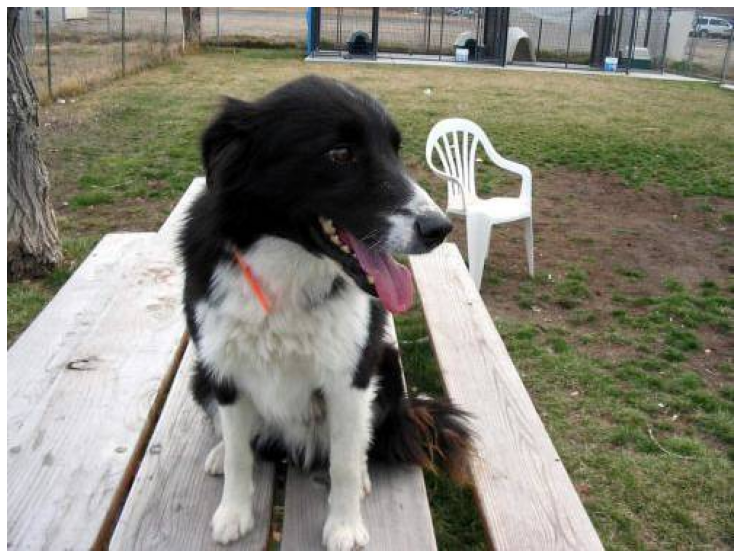

Altura: 374
Largura: 500


In [10]:
image = cv2.imread("/content/gdrive/MyDrive/imagens-testes/dog.3502.jpg") 
show(image)
image_copy = image.copy() 
(H, W) = image.shape[:2]  # pegando a altura e a largura
print("Altura: " + str(H) + "\nLargura: " + str(W))

In [11]:
# Pré-processamento da imagem
def blob_image(net, image):
  #pega a imagem, normaliza, define AxL
  blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
  # passa para as camadas da rede
  net.setInput(blob)
  # pega a classificação das camadas de saída
  layerOutputs = net.forward(ln)
  return net, image, layerOutputs

In [12]:
net, image, layerOutputs = blob_image(net, image)

In [13]:
threshold = 0.5 # Valor utilizado para as detecções
threshold_NMS = 0.3 # Valor Non-Maxima Suppression
boxes = []   # Aqui será armazenado as caixas
conf = []    # Valor de confiança encontrado
IDclass = [] # IDclass para utilizarmos na detecção e plotar label

# Predição

In [14]:
def deteccoes(detection, threshold, boxes, conf, IDclass):
  scores = detection[5:]    # pegando os valores das probabilidades de cada caixa  
  classeID = np.argmax(scores) # pegando o indice do maior valor
  confianca = scores[classeID] # pegando o valor daquele indice

  if confianca > threshold:
      box = detection[0:4] * np.array([W, H, W, H])
      (centerX, centerY, width, height) = box.astype("int") #pegando os valores do centro x,y, altura e largura
      x = int(centerX - (width / 2)) # valor X
      y = int(centerY - (height / 2)) #valor Y

      boxes.append([x, y, int(width), int(height)])
      conf.append(float(confianca))
      IDclass.append(classeID)
      
  return boxes, conf, IDclass

In [15]:
for output in layerOutputs:
    for detection in output:
        boxes, conf, IDclass = deteccoes(detection, threshold, boxes, conf, IDclass)

In [16]:
print(boxes)
print(conf)
print(IDclass)

[[469, 5, 29, 14], [469, 5, 29, 14], [469, 5, 29, 14], [286, 74, 76, 121], [285, 74, 77, 121], [285, 74, 77, 121], [288, 74, 78, 122], [288, 74, 77, 122], [289, 74, 76, 122], [285, 76, 80, 118], [281, 73, 86, 123], [114, 43, 204, 312], [112, 39, 208, 319], [114, 41, 204, 316], [114, 40, 206, 335], [112, 41, 210, 333], [115, 44, 202, 328], [-6, 146, 349, 231], [-4, 148, 347, 229], [-12, 153, 453, 219]]
[0.8169825673103333, 0.7911624908447266, 0.7681090235710144, 0.9907764196395874, 0.9911061525344849, 0.9888720512390137, 0.9264082312583923, 0.9312605261802673, 0.9274721741676331, 0.9965085387229919, 0.7101341485977173, 0.7029613256454468, 0.7204320430755615, 0.7396387457847595, 0.9858558177947998, 0.9872543811798096, 0.984983503818512, 0.5103209614753723, 0.5590859055519104, 0.5332257747650146]
[2, 2, 2, 56, 56, 56, 56, 56, 56, 56, 56, 16, 16, 16, 16, 16, 16, 13, 13, 13]


# Aplicando a NMS

In [17]:
objs = cv2.dnn.NMSBoxes(boxes, conf, threshold, threshold_NMS)
print(len(objs))

3


# Resultado

In [18]:
def funcoes_imagem(image, i, conf, boxes, colors, labels, mostrar_texto=True):
  (x, y) = (boxes[i][0], boxes[i][1])
  (w, h) = (boxes[i][2], boxes[i][3])
  cor = [int(c) for c in colors[IDclass[i]]]
  cv2.rectangle(image, (x, y), (x + w, y + h), cor, 2) 
  texto = "{}: {:.4f}".format(labels[IDclass[i]], conf[i])
  if mostrar_texto:
    print("> " + texto)
    print(x,y,w,h)
  cv2.putText(image, texto, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, cor, 1)

  return image,x,y,w,h

> dog: 0.9873
112 41 210 333


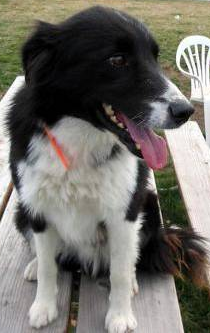

In [19]:
if len(objs) > 0:
  for i in objs.flatten():
    if labels[IDclass[i]] in classes:
      image, x, y, w, h = funcoes_imagem(image, i, conf, boxes, colors, labels)
      objeto = image_copy[y:y + h, x:x + w]
      cv2_imshow(objeto)

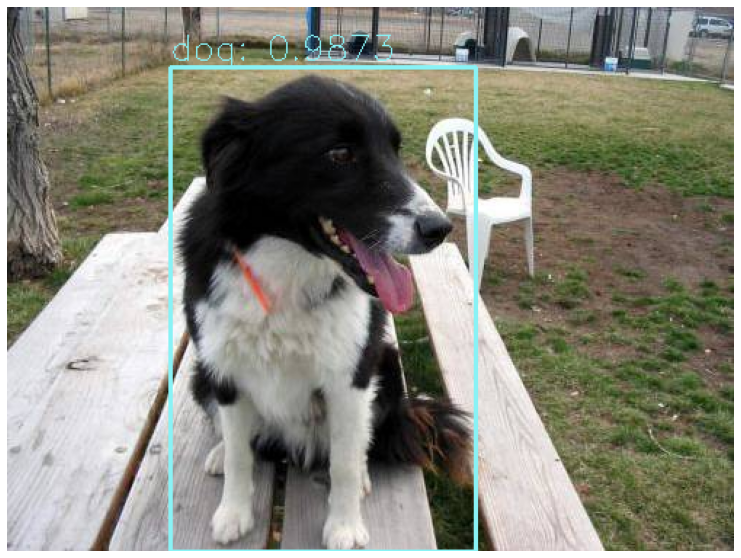

In [20]:
show(image)